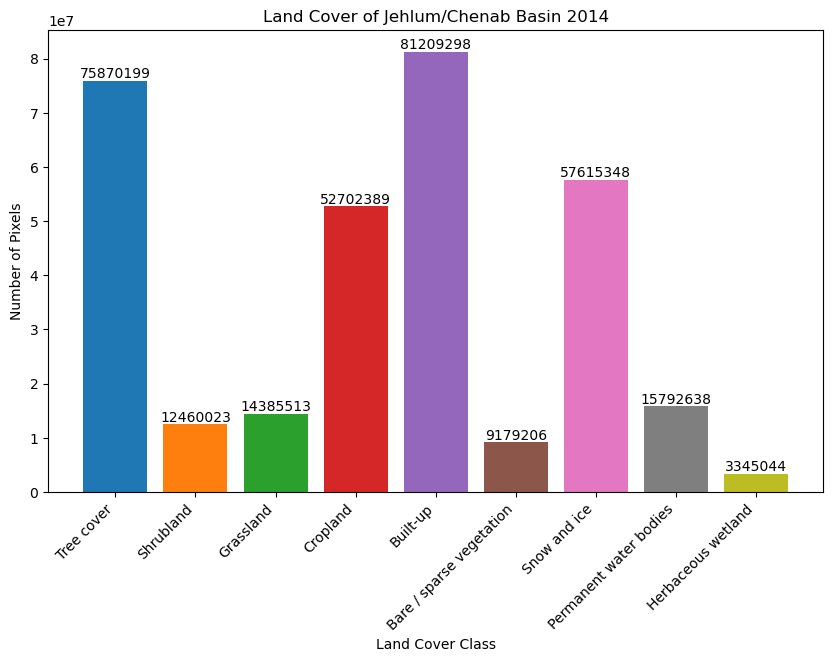

Generating URL ...
Please wait ...
Data downloaded to C:\Users\hanif\Downloads\landcover2014New.tif


In [2]:
import ee
import geemap
import os
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
ee.Initialize()

# Load the shapefile
shapefile = ee.FeatureCollection('projects/ee-hayatabid/assets/Jehlum_Chenab')

# Function to apply scaling factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(
        thermal_bands, None, True
    )

# Load Landsat 8 imagery, filter by location and date, then apply scaling factors
image_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                    .filterBounds(shapefile)
                    .filterDate('2014-05-01', '2014-08-01')
                    .map(apply_scale_factors))

# Create a median mosaic of the image collection
mosaic = image_collection.median()

# Clip the mosaic to the boundaries of the shapefile
clipped_mosaic = mosaic.clip(shapefile.geometry().bounds())

# Visualization parameters
vis_params = {'min': 0.0, 'max': 0.3, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}

# Display the result on the map
Map = geemap.Map()
Map.centerObject(shapefile, 8)
Map.addLayer(clipped_mosaic, vis_params, "Landsat-8 Mosaic")
Map.addLayer(shapefile, {}, 'Shapefile')

# Load ESA WorldCover data and add it to the map
esa = ee.ImageCollection('ESA/WorldCover/v200').first().clip(shapefile.geometry().bounds())
Map.addLayer(esa, {}, 'ESA')

# Create a training dataset from ESA WorldCover data
points = esa.sample(
    **{
        'region': shapefile.geometry().bounds(),
        'scale': 3,
        'numPixels': 50000,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)
Map.addLayer(points, {}, 'training', False)

# Use these bands for prediction
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

# This property of the table stores the land cover labels
label = 'Map'

# Overlay the points on the imagery to get training
training = clipped_mosaic.select(bands).sampleRegions(
    **{'collection': points, 'properties': [label], 'scale': 30}
)

# Train a CART classifier with default parameters
trained = ee.Classifier.smileCart().train(training, label, bands)

# Classify the image with the same bands used for training
result = clipped_mosaic.select(bands).classify(trained)

# Display the clusters with random colors
Map.addLayer(result.randomVisualizer(), {}, 'classified')

# Add land cover classification with ESA WorldCover legend
class_values = esa.get('Map_class_values').getInfo()
class_palette = esa.get('Map_class_palette').getInfo()
class_names = esa.get('Map_class_names').getInfo()

landcover = result.set('classification_class_values', class_values)
landcover = landcover.set('classification_class_palette', class_palette)
landcover = landcover.set('classification_class_names', class_names)

Map.addLayer(landcover, {}, 'Land cover')
Map.add_legend(builtin_legend='ESA_WorldCover')

# Plot a histogram of land cover classes
class_values = esa.get('Map_class_values').getInfo()
class_names = esa.get('Map_class_names').getInfo()

class_counts = result.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=shapefile.geometry().bounds(),
    scale=30,
    maxPixels=1e13
)

histogram_data = class_counts.get('classification').getInfo()
histogram_data = {int(key): value for key, value in histogram_data.items()}
class_values = list(map(int, class_values))

plt.figure(figsize=(10, 6))
for class_value, count in zip(class_values, histogram_data.values()):
    class_name = class_names[class_values.index(class_value)]
    plt.bar(class_name, count)
    plt.text(class_name, count, f'{int(count)}', ha='center', va='bottom')

plt.xlabel('Land Cover Class')
plt.ylabel('Number of Pixels')
plt.title('Land Cover of Jehlum/Chenab Basin 2014')
plt.xticks(rotation=45, ha='right')
plt.show()

# Define the output directory and file path
out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
out_file = os.path.join(out_dir, "landcover2014New.tif")

# Export the image
geemap.ee_export_image(landcover, filename=out_file, scale=900)
